# EEG PREPROCESSING: Final Document

In [99]:
# importing modules
import os
import statistics as st
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# change directory
os.chdir("/work")

## Practicalities 

In [15]:
## loading data ##
raw = mne.io.read_raw_brainvision("58044/Group5/Group5_own.vhdr", eog=('EOG1', 'EOG2'))
raw.load_data()

raw

Extracting parameters from 58044/Group5/Group5_own.vhdr...
Setting channel info structure...
Reading 0 ... 599719  =      0.000 ...   599.719 secs...


<RawBrainVision | Group5_own.eeg, 32 x 599720 (599.7 s), ~146.5 MB, data loaded>

In [16]:
## specyfing the channel location using the montage related functions ##
montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(montage, verbose=False)

<RawBrainVision | Group5_own.eeg, 32 x 599720 (599.7 s), ~146.5 MB, data loaded>

In [17]:
## redefining reference to a common average ##
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group5_own.eeg, 32 x 599720 (599.7 s), ~146.5 MB, data loaded>

Opening raw-browser...


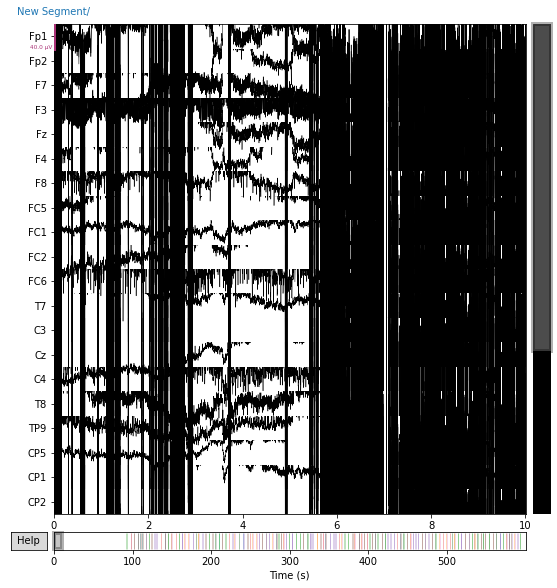

In [18]:
## default plot function ##
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot();

Opening raw-browser...


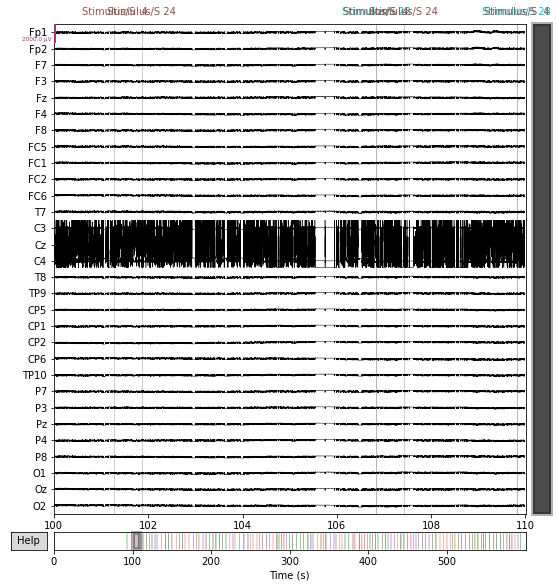

In [19]:
## choosing all channels and scaling (set to auto for now) ##
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot(n_channels = 32, scalings = dict(eeg=100e-5, eog=150e-6), start=100, duration=10);

### Removing Bad Channels

In [20]:
## Removing Cz ## 
raw.info['bads'] = ['Cz']
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')

<RawBrainVision | Group5_own.eeg, 29 x 599720 (599.7 s), ~132.7 MB, data loaded>

Opening raw-browser...


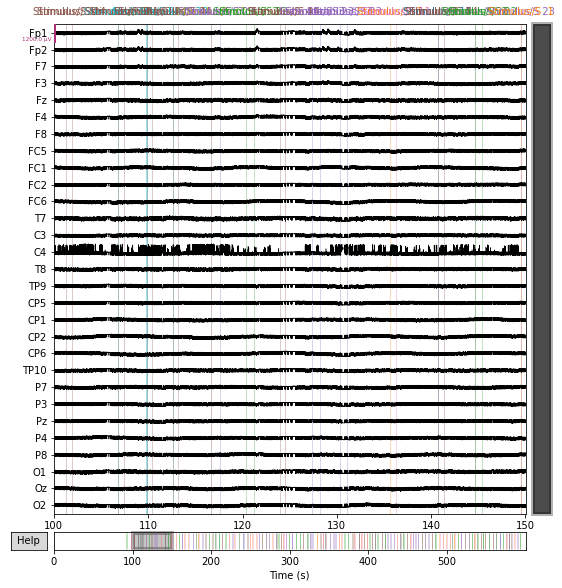

In [21]:
raw.plot(n_channels = 32, scalings = dict(eeg=600e-6, eog=150e-6), start = 100, duration = 50);

In [22]:
## Removing C4 ## 
raw.info['bads'] = ['C4']
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')

<RawBrainVision | Group5_own.eeg, 28 x 599720 (599.7 s), ~128.2 MB, data loaded>

Opening raw-browser...


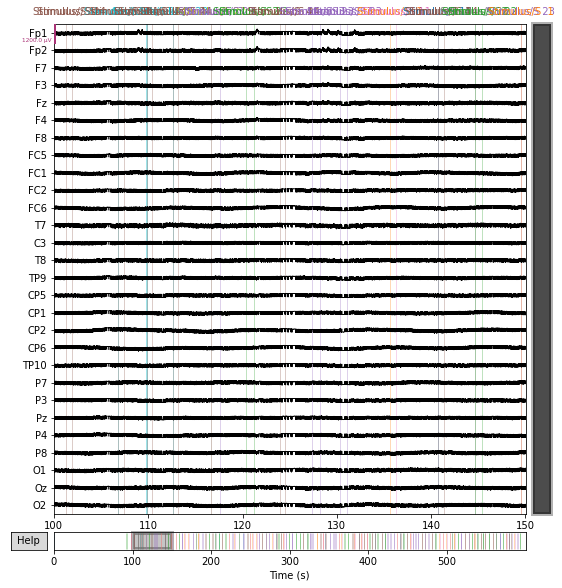

In [23]:
raw.plot(n_channels = 32, scalings = dict(eeg=600e-6, eog=150e-6), start = 100, duration = 50);

## ICA to remove Noise Components Before Filtering 

In [24]:
# set up and fit the ica with 800 iterations with a random seed at 97
# n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data
ica = mne.preprocessing.ICA(n_components=0.95, random_state=98, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 2.8s.


Method,fastica
Fit,12 iterations on raw data (599720 samples)
ICA components,5
Explained variance,95.2 %
Available PCA components,28
Channel types,eeg
ICA components marked for exclusion,—


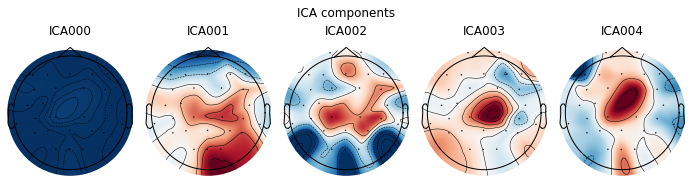

In [25]:
ica.plot_components();

The first ICA is very not good so therefore we inspect it closer

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


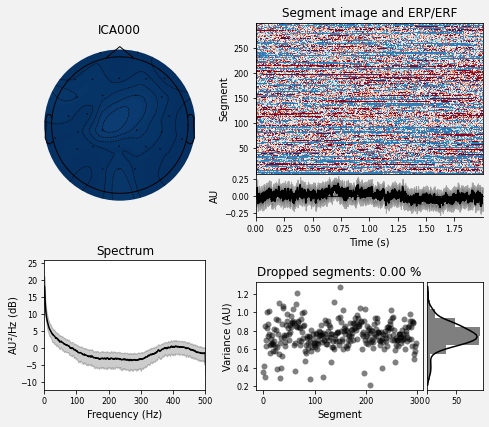

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


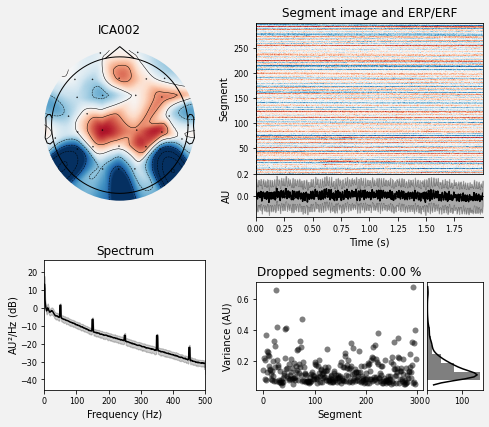

In [26]:
## the first component is excluded based on visual inspection ##
ica.exclude = [0]
ica.plot_properties(raw, picks=ica.exclude);

## further inspection of ICA002
ica.plot_properties(raw, picks=[2]);

In [27]:
## applying the ICA to the data ##
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 28 PCA components


<RawBrainVision | Group5_own.eeg, 28 x 599720 (599.7 s), ~128.2 MB, data loaded>

Opening raw-browser...


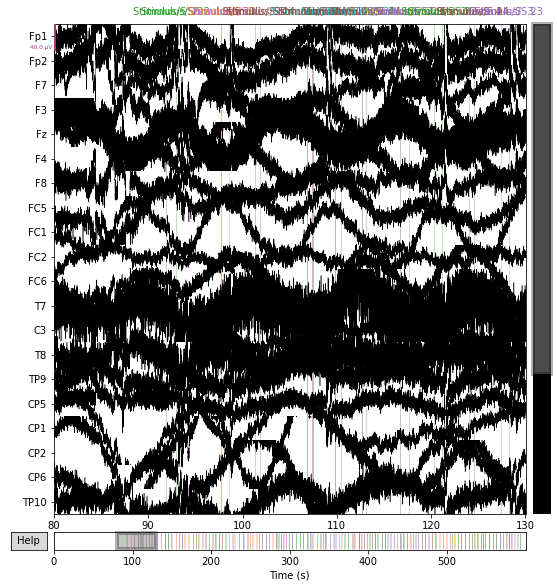

In [28]:
## Looking at the ICA ## 
raw.plot(start = 80, duration = 50);

## Low and High Pass Filtering 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 sec)

Opening raw-browser...


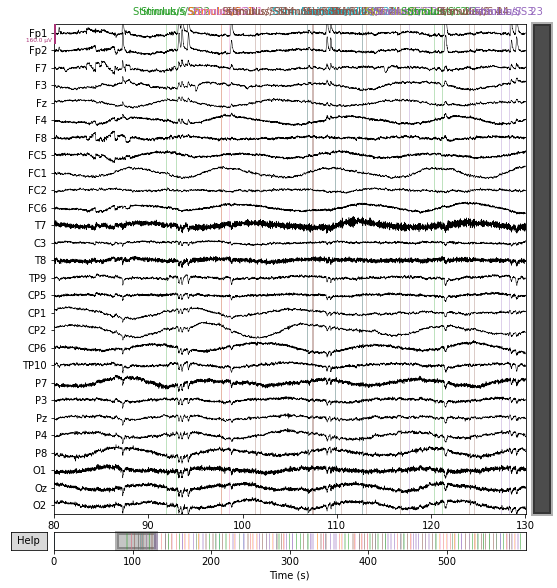

In [29]:
raw = raw.filter(0.1, 40) #high-pass filtering at 0.1 Hz, and low-pass filtering at 40 hZ. 

raw.plot(n_channels = 32, scalings = dict(eeg=80e-6, eog=150e-6), start=80, duration = 50);

## CODING IN TRIGGERS / EVENTS (Preprocessing) 

In [30]:
# extracting the triggers
info = mne.events_from_annotations(raw)

# isolating all events 
events_raw = info[0]

# uniques?
event_id_np = np.unique(events_raw[:,2])
event_id_np

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28']


array([    1,     2,     3,     4,    11,    12,    13,    14,    15,
          21,    22,    23,    24,    25,    26,    27,    28, 99999])

In [31]:
## setting up event dictionary ##
event_id = {'Word/Realwords': 1,
            'Word/CenterShuffled': 2, 
            'Word/Pseudowords': 3, 
            'Word/Nonwords': 4,
            'Decision/YesReal': 11,
            'Decision/YesCenter': 12,
            #'Decision/YesFully': 13,
            #'Decision/YesForeign': 14, 
            'Decision/NoReal': 21, 
            'Decision/NoCenter': 22,
            'Decision/NoPseudo': 23,  
            'Decision/NoNon': 24,}

## setting up FALSE event dictionary ##
event_id_FALSE = {'15': 15,
            '25': 25, 
            '26': 26, 
            '27': 27,
            '28': 28,
            '99999': 99999, 
           }

In [32]:
indexes = np.where((events_raw[:, 2] == 15)|(events_raw[:, 2] == 25)|(events_raw[:, 2] == 26)|(events_raw[:, 2] == 27)|(events_raw[:, 2] == 28)| (events_raw[:, 2] == 99999))

print(len(events_raw))
print(len(indexes[0]))

293
33


In [33]:
# Removing fakes 
fake_triggers = [15, 25, 26, 27, 28, 99999]

events = events_raw 

for i in range(len(events_raw[:,2])):
    if events[i,2] in fake_triggers:
        events = np.delete(events, i, axis = 0)

IndexError: index 260 is out of bounds for axis 0 with size 260

In [34]:
#print(events)

Our total length of events is 293, and we found that 33 were fake i.e., not defined by us, so it checks out!! However, we had 124 trials woops. So we have found several multiples of actual triggers (e.g., 22 and 24 coming right after each other). 

In [35]:
for i in range(len(events[:,2])):
    if events[i,0] == events[i+1,0]-1:
        events = np.delete(events, i, axis = 0)

IndexError: index 248 is out of bounds for axis 0 with size 248

In [36]:
print(len(events)) #it works babe

248


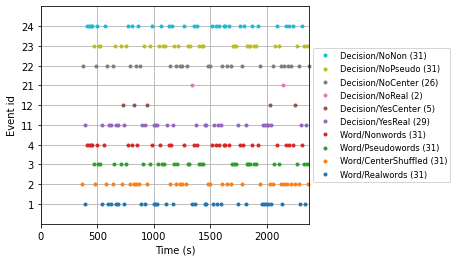

In [37]:
# plotting the events 
mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);

## EPOCHING

In [38]:
# setting time window 
tmin, tmax = -0.1, 0.7

# choosing only EEG channels for epoching (thus EOG false) 
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

#reject criterion of 150 microvolts
reject = dict(eeg=150e-6)

# epochs 
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)


Not setting metadata
248 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 248 events and 801 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
7 bad epochs dropped


Only 7 out of 293 epochs have been dropped *dab*

## DOWNSAMPLING

In [39]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

# ERP TIME

In [40]:
word_epochs = epochs_resampled['Word']
decision_epochs = epochs_resampled['Decision']

Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


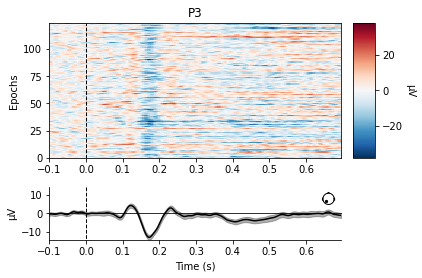

Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


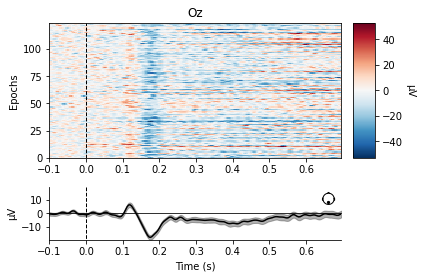

In [41]:
word_epochs.plot_image(picks=["P3"]); 
word_epochs.plot_image(picks=["Oz"]); 

## Differences between Conditions 

In [43]:
## Preprocessing part ##
word_real_epochs = epochs_resampled['Word/Realwords']
word_cs_epochs = epochs_resampled['Word/CenterShuffled']
word_pseudo_epochs = epochs_resampled['Word/Pseudowords']
word_non_epochs = epochs_resampled['Word/Nonwords']


word_real_evoked = word_real_epochs.average()
word_cs_evoked = word_cs_epochs.average()
word_pseudo_evoked = word_pseudo_epochs.average()
word_non_evoked = word_non_epochs.average()


No projector specified for this dataset. Please consider the method self.add_proj.


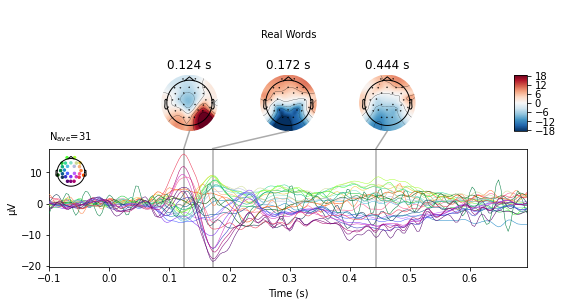

No projector specified for this dataset. Please consider the method self.add_proj.


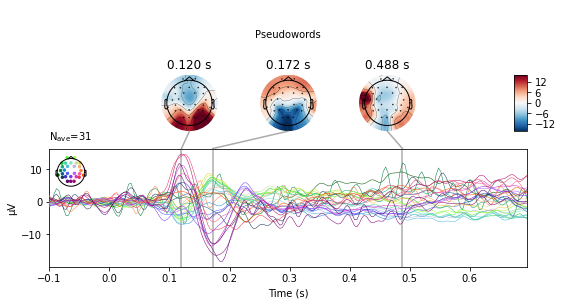

No projector specified for this dataset. Please consider the method self.add_proj.


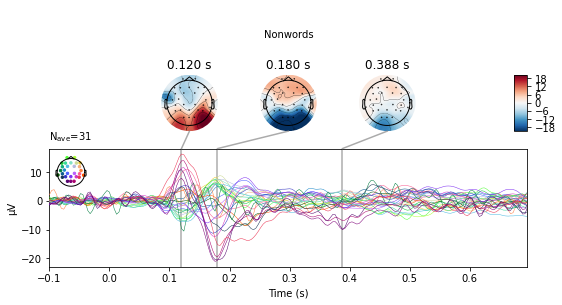

In [ ]:
## Plotting ##
word_real_plot = word_real_evoked.plot_joint(picks='eeg', title = "Real Words");

word_pseudo_plot = word_pseudo_evoked.plot_joint(picks='eeg', title = "Pseudowords");

word_non_plot = word_non_evoked.plot_joint(picks='eeg', title = "Nonwords");

### Playing Around with Evoked Plots 

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


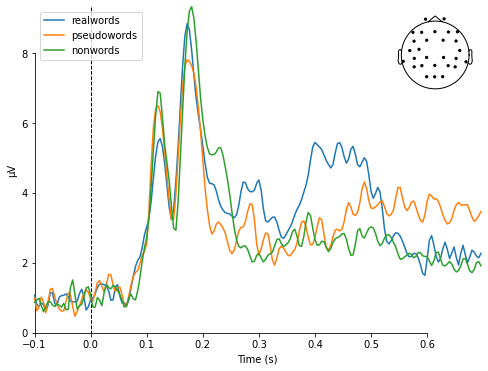

[<Figure size 576x432 with 2 Axes>]

In [57]:
#all evokeds in a dict
evokeds = dict(realwords=word_real_evoked, pseudowords = word_pseudo_evoked, nonwords = word_non_evoked)

# plotting the two evokeds together
mne.viz.plot_compare_evokeds(evokeds, legend='upper left', show_sensors='upper right')

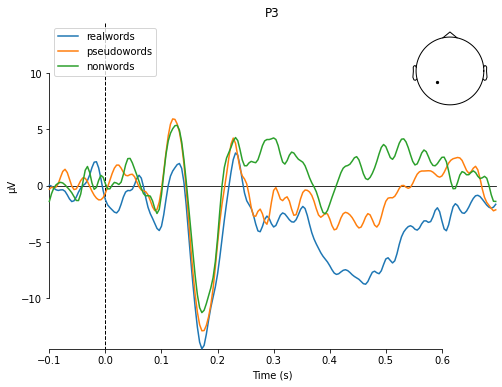

[<Figure size 576x432 with 2 Axes>]

In [58]:
p3_evoked_plot = mne.viz.plot_compare_evokeds(evokeds, picks='P3')
p3_evoked_plot

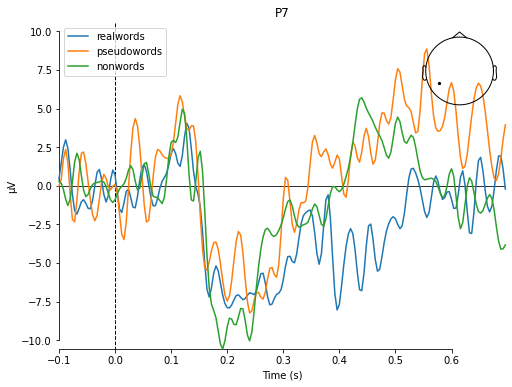

[<Figure size 576x432 with 2 Axes>]

In [48]:
mne.viz.plot_compare_evokeds(evokeds, picks='P7')

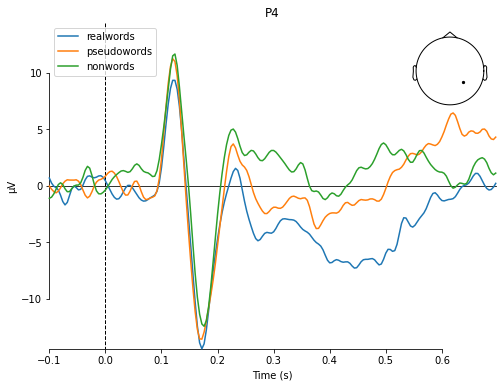

[<Figure size 576x432 with 2 Axes>]

In [49]:
mne.viz.plot_compare_evokeds(evokeds, picks='P4')

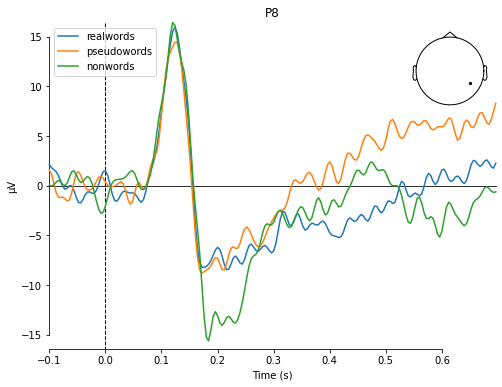

[<Figure size 576x432 with 2 Axes>]

In [50]:
mne.viz.plot_compare_evokeds(evokeds, picks='P8')

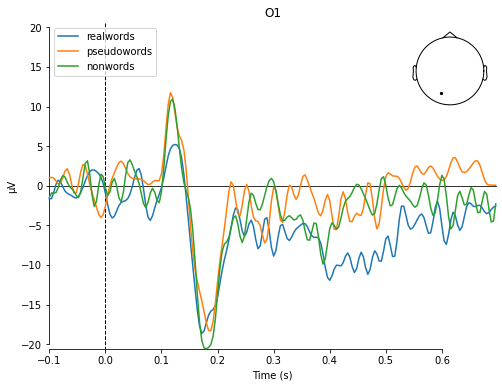

[<Figure size 576x432 with 2 Axes>]

In [59]:
mne.viz.plot_compare_evokeds(evokeds, picks='O1')

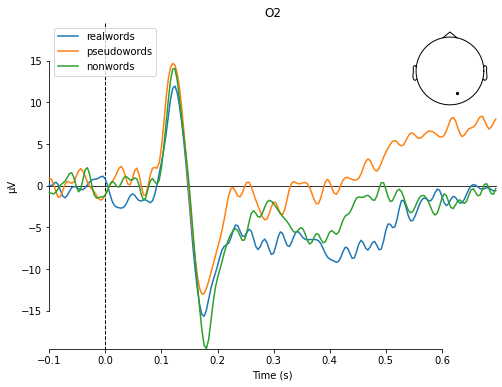

[<Figure size 576x432 with 2 Axes>]

In [60]:
mne.viz.plot_compare_evokeds(evokeds, picks='O2')

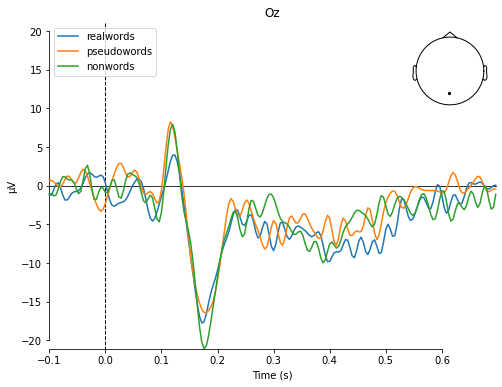

[<Figure size 576x432 with 2 Axes>]

In [61]:
mne.viz.plot_compare_evokeds(evokeds, picks='Oz')

#### N170

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


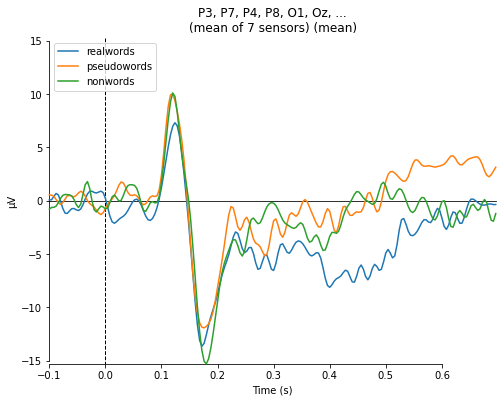

[<Figure size 576x432 with 1 Axes>]

In [62]:
mne.viz.plot_compare_evokeds(evokeds, picks=['P3', 'P7', "P4", "P8", "O1", "Oz", "O2"], combine = "mean")

#### N400

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


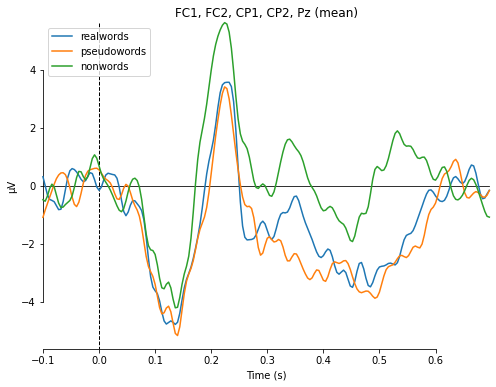

[<Figure size 576x432 with 1 Axes>]

In [86]:
mne.viz.plot_compare_evokeds(evokeds, picks=["FC1", "FC2", "CP1", "CP2", "Pz"], combine = "mean") #should we include C3??

## Saving EPOCHS as object for use in EEG_OWN_STATS.ipynb 

In [65]:
#saving our EPOCHS as an object
epochs_resampled.save('AntonMina_epochs-epo.fif')

## Connecting RT with EEG 

In [66]:
trial = [] #trial number
reaction_time = []
condition = []
response = [] #yes / no 

for i in range(0, len(events), 2): 
    trial.append(len(trial)+1)
    reaction_time.append((events[i+1,0] - events[i,0])/1000)
    condition.append(events[i, 2])
    response.append(int(str(events[i+1,2])[0]))


In [68]:
data = pd.DataFrame({"Trial":trial, "Condition": condition, "Response":response, "Reaction Time":reaction_time})

In [69]:
print(data)

     Trial  Condition  Response  Reaction Time
0        1          2         2          1.100
1        2          1         1          0.791
2        3          4         2          0.583
3        4          4         2          0.582
4        5          4         2          0.616
..     ...        ...       ...            ...
119    120          4         2          0.616
120    121          3         2          0.866
121    122          1         1          1.683
122    123          3         2          0.699
123    124          2         2          0.773

[124 rows x 4 columns]


#### Re-Epoching without Rejection to work with RT

In [71]:
# establishing time window
tmin, tmax = -0.1, 1

# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, eeg=True, eog=False)

# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs_unreject = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=None, preload=True)

# downsampling to 250 Hz
epochs_unreject = epochs_unreject.resample(250)


Not setting metadata
248 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 248 events and 1101 original time points ...
0 bad epochs dropped


#### Prep for Plotting

In [74]:
real_epochs_unreject = epochs_unreject["Word/Realwords"]
non_epochs_unreject = epochs_unreject["Word/Nonwords"]
pseudo_epochs_unreject = epochs_unreject["Word/Pseudowords"]

def overlay_times(Condition):
    return [data["Reaction Time"].values[i] for i in range(len(data["Reaction Time"])) if data["Condition"].values[i] == Condition]

def order(Condition):
    overlay = overlay_times(Condition)
    overlay_index = [i for i in range(len(overlay))]
    overlay_zipped = list(zip(overlay, overlay_index))
    overlay_zipped.sort()
    overlay_unzipped = list(zip(*overlay_zipped))
    overlay_index_sorted = overlay_unzipped[1]
    return overlay_index_sorted
    
overlay_real = overlay_times(1)
overlay_pseudo = overlay_times(3)
overlay_non = overlay_times(4)

order_real = order(1)
order_pseudo = order(3)
order_non = order(4)



#### Doing the Plotting

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


/tmp/ipykernel_737/2742737263.py:2: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.1 s and 0.9960000000000001 s)
  real_epochs_unreject.plot_image(picks=['C3', 'CP1', 'CP2', 'CP5', 'CP6'], overlay_times = overlay_real, order = order_real, combine = 'mean')


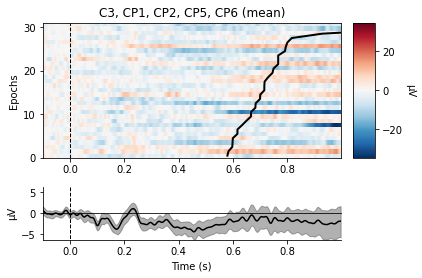

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


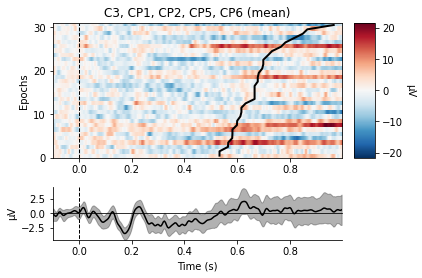

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


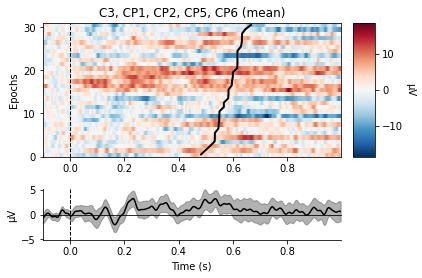

[<Figure size 432x288 with 3 Axes>]

In [75]:
# plotting the C-channels
real_epochs_unreject.plot_image(picks=['C3', 'CP1', 'CP2', 'CP5', 'CP6'], overlay_times = overlay_real, order = order_real, combine = 'mean')
pseudo_epochs_unreject.plot_image(picks=['C3', 'CP1', 'CP2', 'CP5', 'CP6'], overlay_times = overlay_pseudo, order = order_pseudo, combine = 'mean')
non_epochs_unreject.plot_image(picks=['C3', 'CP1', 'CP2', 'CP5', 'CP6'], overlay_times = overlay_non, order = order_non, combine = 'mean')

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


/tmp/ipykernel_737/3481523761.py:2: RuntimeWarning: Some values in overlay_times fall outside of the epochs time interval (between -0.1 s and 0.9960000000000001 s)
  real_epochs_unreject.plot_image(picks=['FC1', 'FC2', 'FC5', 'FC6', 'C3'], overlay_times = overlay_real, order = order_real, combine = 'mean')


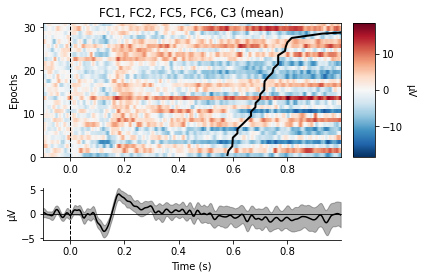

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


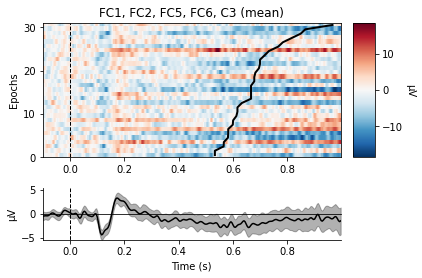

Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


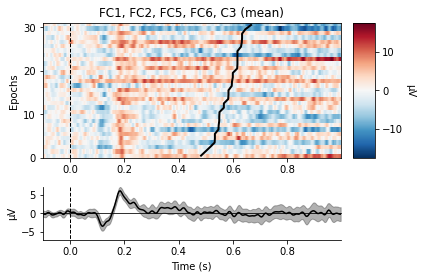

[<Figure size 432x288 with 3 Axes>]

In [76]:
# plotting the FC-channels
real_epochs_unreject.plot_image(picks=['FC1', 'FC2', 'FC5', 'FC6', 'C3'], overlay_times = overlay_real, order = order_real, combine = 'mean')
pseudo_epochs_unreject.plot_image(picks=['FC1', 'FC2', 'FC5', 'FC6', 'C3'], overlay_times = overlay_pseudo, order = order_pseudo, combine = 'mean')
non_epochs_unreject.plot_image(picks=['FC1', 'FC2', 'FC5', 'FC6', 'C3'], overlay_times = overlay_non, order = order_non, combine = 'mean')

#### Re-Doing Evoked Plots Looking at Time-Windows Corresponding to the RTs

In [77]:
word_real_evoked = real_epochs_unreject.average()
word_pseudo_evoked = pseudo_epochs_unreject.average()
word_non_evoked = non_epochs_unreject.average()

No projector specified for this dataset. Please consider the method self.add_proj.


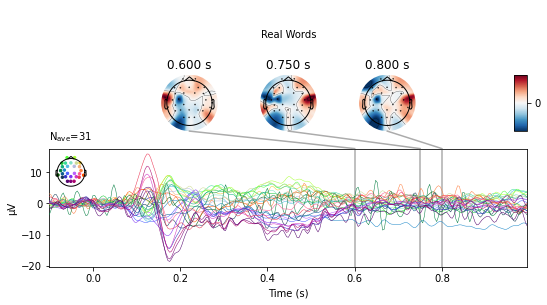

No projector specified for this dataset. Please consider the method self.add_proj.


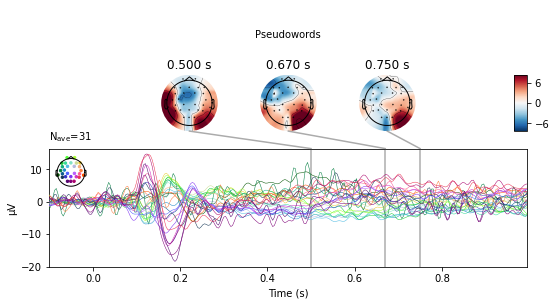

No projector specified for this dataset. Please consider the method self.add_proj.


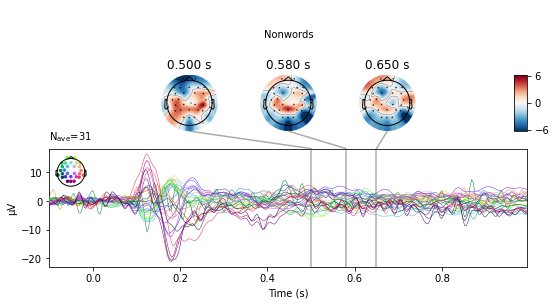

In [84]:
## categorising ##
word_real_plot = word_real_evoked.plot_joint(picks='eeg', title = "Real Words", times = [0.6, 0.75, 0.8]);

word_pseudo_plot = word_pseudo_evoked.plot_joint(picks='eeg', title = "Pseudowords", times = [0.5, 0.67, 0.75]);

word_non_plot = word_non_evoked.plot_joint(picks='eeg', title = "Nonwords", times = [0.5, 0.58, 0.65]);

### Aggregate statistics / plots

In [83]:
# Adding Correct Column (1 = correct, 0 = incorrect)
correct = []

for i in range(len((data))):
    if data["Condition"][i] == 1 and data["Response"][i] == 1:
        correct.append(1)
    elif data["Condition"][i] == 2 or data["Condition"][i] == 3 or data["Condition"][i] == 4 and data["Response"][i] == 2:
        correct.append(1)
    else:
        correct.append(0)    
            
data["Correct"] = correct

In [130]:
## average reaction time by condition ##
mean_data = data.groupby("Condition").mean()

st_data = data.groupby("Condition").std()
st_mean_data = pd.DataFrame({"Mean RT":mean_data["Reaction Time"], "SD":st_data["Reaction Time"], "Correct":mean_data["Correct"]})

st_mean_data

,Mean RT,SD,Correct
Condition,,,
1,0.750323,0.211997,0.935484
2,0.789355,0.181196,1.000000
3,0.674387,0.102103,1.000000
4,0.581355,0.045594,1.000000


In [ ]:
# Plotting Reaction Times
plt.hist(data["Reaction Time"])

In [ ]:
# Plotting Reaction Times by Condition
data["Reaction Time"].hist(by=data["Condition"])